Author: 

In [309]:
# Some imports to get us started

import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import xgboost
from xgboost import XGBRegressor, XGBClassifier

# EconML imports
from econml.dr import LinearDRLearner

# DoWhy imports 
import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Loan is the main profit source for a bank with the profit mainly generated from the interest paid on the loan. Inorder to get this process profitable, the bank needs to know if the loan applicant will be able to pay back the loan along with the interest. Inorder to make this decision, in this article, we discuss the Bayesian Network way of predicting the eligibility of the loan applicant.  In doing so we will discuss about how different variables are involved to understand the causal relationship which helps us to find the conditional probability for different states of the variables in the network. 

The task is learn a Bayesian Network for finding the loan elligibility for the applicant who wants to buy a Property in one of the three different areas. 



# Data Exploration and Preprocessing

Before starting with Baysian Network learning, we need to explore the dataset and preprocess it for the task in hand. We are going to be using the loan eligibility dataset at https://github.com/mridulrb/Predict-loan-eligibility-using-IBM-Watson-Studio/tree/master/Dataset

For our purposes, we are going to use pandas for loading the csv files in the provided dataset. We are going to load train set to form one dataframe called "data". In this case, we are not using test file and will make data for testing from samples in train file since test file does not have the ground truth. We do this for preprocessing all the data together. Later for inference using BN, we are going to split this data into test and train dataframes.

In [310]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
data=pd.read_csv("Loan_data.csv")

In [311]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


We can use the data.head() command to see the top few rows of the loaded dataframe. This gives us an idea about different variables involved. A quick look at "LoanAmount" shows that there are also missing values in the dataset labelled with Nan. This is normally the case and we first need to find out the missing values for each of the variables and then fill them up.

For this purpose, we are going to apply isnull function using the code given in the cell below, which finds the missing values for each variable in the dataset

In [312]:
data.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

We can see that some of the variables have missing values. Depending upon the type of variable, we are going to use mode for categorical variables for filling missing values and mean for filling numerical variables.

In [313]:
#categorical
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
#numerical
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)

In this work, we are going to be utilzing the Bayesian Network Strucuture learning method of causalNex for learning the causal relationships between the variables. Although, for the case of loan eligibility problem and in general, there is a need for domain knowledge for setting up the structure of the BN but first we are going to use the inbuilt algorithms in causalNex to demonstrate autmatic learning using causalNex. Later on, we will use domain knowledge for Loan eligibility to setup a structure for BN. The structure leanring function of causalNex requires the data to be in numeric form so we are going to first convert the data for this purpose.

We begin by finding the columns which have categorical form and the following code snippet can be used to extract the columns that corresspond to categorical variables

In [314]:
drop_col = ['Loan_ID']
data = data.drop(columns=drop_col)

In [315]:
import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


For this work, we are also going to convert the numerical variables into categories for causelNex implementation. For this data, we have the following variables currently corressponding to numerical variables:

LoanAmount

ApplicantIncome

Coapplicantincome

Loan_Amount_Term


First, for the sake of easy demonstration, we are going sum the ApplicantIncome and Coapplicantincome into one variable called TotalIncome and drop the variables ApplicantIncome and CoapplicantIncome from the overall data. The following code snippet can be used for this purpose.

In [316]:
struct_data['TotalIncome']= struct_data['ApplicantIncome'] +struct_data['CoapplicantIncome'] 
drop_col = ['ApplicantIncome','CoapplicantIncome']
struct_data = struct_data.drop(columns=drop_col)

Inorder to ultimately convert the numerical variables into catergorical, we first need to discretize the numerical variables. Inorder to box thse variables into discrete bins, we first need to decide the bin boundaries. For this purpose we are going to use boxplot and hitogram to visualize these variables

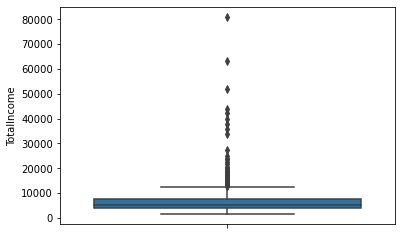

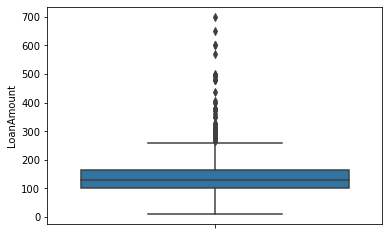

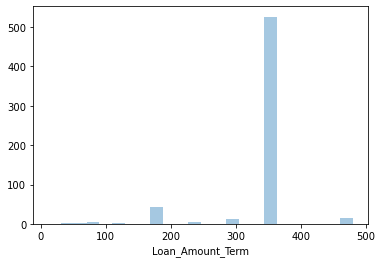

In [317]:
sns.boxplot(y='TotalIncome',data=struct_data)
plt.figure()
sns.boxplot(y='LoanAmount',data=data)
plt.figure()
sns.distplot(data.Loan_Amount_Term.dropna(),kde=False)
plt.show()




We can see from the above plots that the following boundaries can be used for the variables:

TotalIncome = [15000,50000]

LoanAmount = [200,550]

Loan_Amount_Term = [365]


Now that we have the boundaries, we need to convert the variables into descretized values

In [318]:
discretised_data = struct_data.copy()

In [319]:

discretised_data = struct_data.copy()
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
discretised_data[['TotalIncome','LoanAmount','Loan_Amount_Term']] = scaler.fit_transform(discretised_data[['TotalIncome','LoanAmount','Loan_Amount_Term']])
print(discretised_data.head)

<bound method NDFrame.head of      Gender Married Dependents     Education Self_Employed  LoanAmount  \
0      Male      No          0      Graduate            No    0.198860   
1      Male     Yes          1      Graduate            No    0.172214   
2      Male     Yes          0      Graduate           Yes    0.082489   
3      Male     Yes          0  Not Graduate            No    0.160637   
4      Male      No          0      Graduate            No    0.191027   
..      ...     ...        ...           ...           ...         ...   
609  Female      No          0      Graduate            No    0.089725   
610    Male     Yes         3+      Graduate            No    0.044863   
611    Male     Yes          1      Graduate            No    0.353111   
612    Male     Yes          2      Graduate            No    0.257598   
613  Female      No          0      Graduate           Yes    0.179450   

     Loan_Amount_Term  Credit_History Property_Area Loan_Status  TotalIncome  
0 

After descrtising the data, we can then map the bins into different categories. We use three different categories for TotalIncome & LoanAmount i.e low, medium, high and two categories for Loan_Amount_Term.

We can now use the non-numeric variables and map them into numeric form since the BN structure learning model requries numeric variables

In [320]:
from sklearn.preprocessing import LabelEncoder
non_numeric_columns = list(discretised_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    discretised_data[col] = le.fit_transform(discretised_data[col])
discretised_data["Credit_History"] = discretised_data["Credit_History"].astype(int)


discretised_data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,1,0,0,0,0,0.198860,0.74359,1,2,1,0.055394
1,1,1,1,0,0,0.172214,0.74359,1,0,0,0.058435
2,1,1,0,0,1,0.082489,0.74359,1,2,1,0.019583
3,1,1,0,1,0,0.160637,0.74359,1,2,1,0.043980
4,1,0,0,0,0,0.191027,0.74359,1,2,1,0.057292


Since DoWhy is based on Causal Inference, we need to make a sample treatment Financial Advice: maps to 0 for no, 1 for yes.
The Financial_Advice_func function has defined a treatment taking into account all relevant features.

In [322]:
discretised_data['Financial_Advice']=0
discretised_data['IncomeComb']=0
for i in range(discretised_data.shape[0]):
    if discretised_data.Education[i]==0:
        if discretised_data.Self_Employed[i]==0:
            discretised_data.IncomeComb[i]=1
        else:
            discretised_data.IncomeComb[i]=0
    else:
            discretised_data.IncomeComb[i]=1
            
def Financial_Advice_func(W):
    for i in range(W.shape[0]):
        if W['IncomeComb'][i]==1:            
            W['Financial_Advice'][i]=(500 * W['Credit_History'][i] - 1000 * W['LoanAmount'][i] + 800*W['Property_Area'][i]
                   -700*W['Loan_Amount_Term'][i] +500*W['TotalIncome'][i] -500*W['Dependents'][i]) 
        else:
            W['Financial_Advice'][i]=(500 * W['Credit_History'][i] - 1000 * W['LoanAmount'][i] + 800*W['Property_Area'][i]
                   -700*W['Loan_Amount_Term'][i] - 500*W['TotalIncome'][i] -500*W['Dependents'][i]) 

Financial_Advice_func(discretised_data)
for i in range(discretised_data.shape[0]):
    if (discretised_data['Financial_Advice'][i]> discretised_data['Financial_Advice'].mean()):
        discretised_data['Financial_Advice'][i] = 1
    else:
        discretised_data['Financial_Advice'][i] = 0
print(discretised_data.head)

<bound method NDFrame.head of      Gender  Married  Dependents  Education  Self_Employed  LoanAmount  \
0         1        0           0          0              0    0.198860   
1         1        1           1          0              0    0.172214   
2         1        1           0          0              1    0.082489   
3         1        1           0          1              0    0.160637   
4         1        0           0          0              0    0.191027   
..      ...      ...         ...        ...            ...         ...   
609       0        0           0          0              0    0.089725   
610       1        1           3          0              0    0.044863   
611       1        1           1          0              0    0.353111   
612       1        1           2          0              0    0.257598   
613       0        0           0          0              1    0.179450   

     Loan_Amount_Term  Credit_History  Property_Area  Loan_Status  \
0           

# Causal Estimation

Now that we have preprocessed the data, we can start to build models using the DoWhy library which we will install below.

In [323]:
pip install dowhy

Note: you may need to restart the kernel to use updated packages.


The DoWhy library is primarily based on finding out if there exists a causal effect between two variables: the treatment variable and the the outcome variable.

In this Jupyter notebook, we can estimate one variable by variable basis i.e Map the effect of Financial_Advice on Loan Status (Outcome) or we can train a simple linear regressor to give an output of all the variables we want to check for influence.

This library is primarily a library that can check for effects of various Financial_Advices along with their marginal costs to determine the effectiveness of Financial_Advice.

A sample Financial_Advice is given here, which is Financial_Advice


Now we will create a graph of all the factors influencing our outcome variable here: the Loan_Status

In [324]:
import graphviz

The edges added here, show the assumptions made by the graph before evaluating the model and estabilishing relationships

digraph {
	LoanAmount [label=LoanAmount]
	Self_Employed [label=Self_Employed]
	Education [label=Education]
	Loan_Status [label=Loan_Status]
	Dependents [label=Dependents]
	Loan_Amount_Term [label=Loan_Amount_Term]
	Property_Area [label=Property_Area]
	Credit_History [label=Credit_History]
	TotalIncome [label=TotalIncome]
	Financial_Advice [label=Financial_Advice]
	IncomeComb -> TotalIncome
	Dependents -> Financial_Advice
	Credit_History -> Financial_Advice
	LoanAmount -> Financial_Advice
	TotalIncome -> Financial_Advice
	Education -> IncomeComb
	Property_Area -> Financial_Advice
	Self_Employed -> IncomeComb
	Loan_Amount_Term -> Financial_Advice
	Financial_Advice -> Loan_Status
}



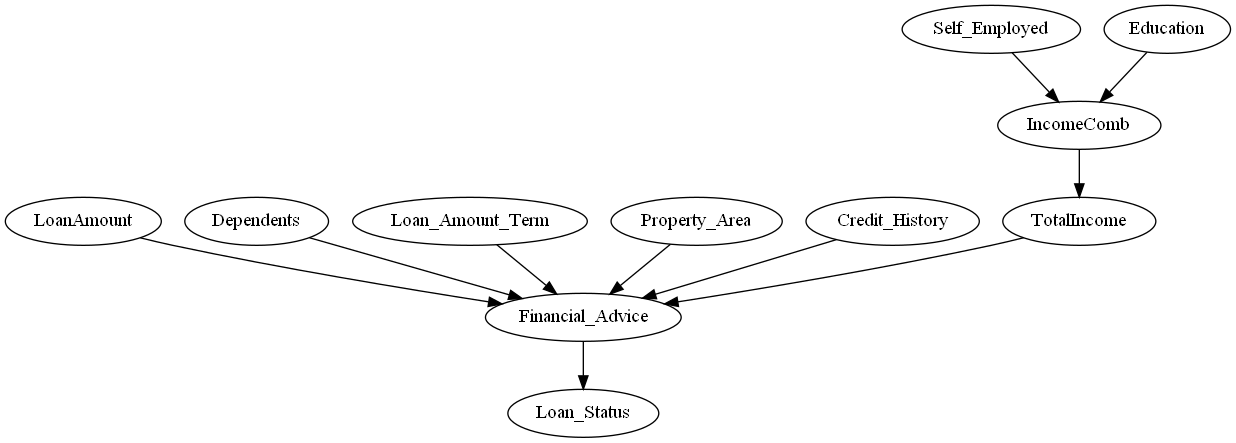

In [327]:
from IPython.display import Image, display

dot = graphviz.Digraph() 

dot.node('LoanAmount', 'LoanAmount')  
dot.node('Self_Employed', 'Self_Employed')
dot.node('Education', 'Education')
dot.node('Loan_Status', 'Loan_Status')
dot.node('Dependents','Dependents')
 
dot.node('Loan_Amount_Term','Loan_Amount_Term')
dot.node('Property_Area', 'Property_Area')
dot.node('Credit_History', 'Credit_History')
dot.node('TotalIncome', 'TotalIncome')
dot.node('Financial_Advice','Financial_Advice')

dot.edge('IncomeComb','TotalIncome')
dot.edge('Dependents','Financial_Advice')
dot.edge('Credit_History','Financial_Advice')
dot.edge('LoanAmount','Financial_Advice')
dot.edge('TotalIncome','Financial_Advice')
dot.edge('Education','IncomeComb')
dot.edge('Property_Area','Financial_Advice')
dot.edge('Self_Employed','IncomeComb')
dot.edge('Loan_Amount_Term','Financial_Advice')
dot.edge('Financial_Advice','Loan_Status')

print(dot.source)

dot.format = 'png'
dot.render(directory='doctest-output', view = True).replace('\\', '/')
display(Image(filename="Digraph.gv.png"))

We can see a basic digraph for the assumptions made in the Loan_Status feature.

We now divide the features into their relevant categories.

In [328]:
# Define estimator inputs
discretised_data2 = discretised_data[['TotalIncome','Credit_History','Property_Area','Loan_Amount_Term','Dependents','Education','Self_Employed','LoanAmount']]
test_data = discretised_data.iloc[:1000]
T = discretised_data["Financial_Advice"]  # multiple interventions, or Financial_Advices
Y = discretised_data["Loan_Status"]  # amount of product purchased, or outcome

X= discretised_data2
Z = discretised_data['IncomeComb'] # nudge, or instrument



Now using EconML which is integrated with DoWhy we define the parameters for an XGBOOST classifier.

In [329]:
# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

Using EconML's Linear DRM estiamtor, we can check for the causal relationship between the treatment and the outcome.

In [332]:
est = LinearIntentToTreatDRIV(model_t_xwz=model_T_XZ, model_y_xw=model_Y_X,
                            flexible_model_effect=flexible_model_effect,
                            featurizer=PolynomialFeatures(degree=1, include_bias=False))

# fit through dowhy
test_data = X.iloc[:1000]
est_dw=est.dowhy.fit(Y, T,Z=Z, X=X, outcome_names=["Loan_Status"], treatment_names=["Financial_Advice"], 
                     feature_names=list(discretised_data2.columns.values), target_units=test_data,
                     inference="statsmodels")

Here we can see 2 causal relationships present between the treatment and outcome

In [233]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(E[Loan_Status|LoanAmount,Property_Area,Dependents,TotalIncome,Sel
d[Treatment]                                                                  

                                                      
f_Employed,Loan_Amount_Term,Education,Credit_History])
                                                      
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Loan_Status then P(Loan_Status|Treatment,LoanAmount,Property_Area,Dependents,TotalIncome,Self_Employed,Loan_Amount_Term,Education,Credit_History,U) = P(Loan_Status|Treatment,LoanAmount,Property_Area,Dependents,TotalIncome,Self_Employed,Loan_Amount_Term,Education,Credit_History)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                       -1⎤
 ⎢      d                    ⎛      d   

# Evaluating the Estimand

We will now see the effect of the treatment on each of the data rows given whether the treatment caused a postive relation to having a loan status of 1 or a negative relation to the loan status of 1.

The realized estimand also gies a relationship between the features, and the mean value of the estimate shows the effectiveness of the feature.

In [333]:
lineardml_estimate = est_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
───────────────────(E[Loan_Status|LoanAmount,Property_Area,Dependents,TotalInc
d[Financial_Advice]                                                           

                                                             
ome,Self_Employed,Loan_Amount_Term,Education,Credit_History])
                                                             
Estimand assumption 1, Unconfoundedness: If U→{Financial_Advice} and U→Loan_Status then P(Loan_Status|Financial_Advice,LoanAmount,Property_Area,Dependents,TotalIncome,Self_Employed,Loan_Amount_Term,Education,Credit_History,U) = P(Loan_Status|Financial_Advice,LoanAmount,Property_Area,Dependents,TotalIncome,Self_Employed,Loan_Amount_Term,Education,Credit_History)

## Realized estimand
b: Loan_Status~Financial_Advice+LoanAmount+Pro

Using EconML's Singletreecateinterpreter, we can see the effect of the treatment on Loan_Amount_Term and Property_Area.

The redder a box the more negative an effect, while the greener a box the more positive effect a treatment had towards achieving a loan status of 1.

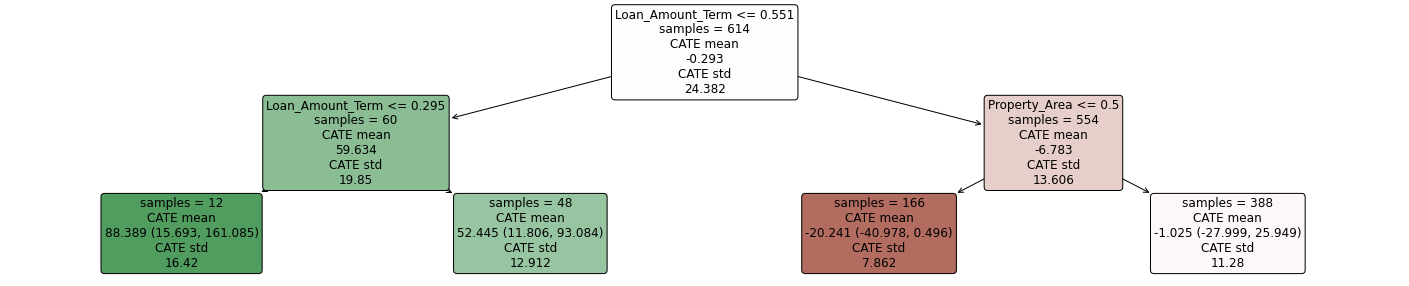

In [334]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_dw, test_data)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

Then using the policy interpreter, we can check for the improvements made over the treatment policy and the recommended treatment: given treatment of 0 or No Financial Advice.

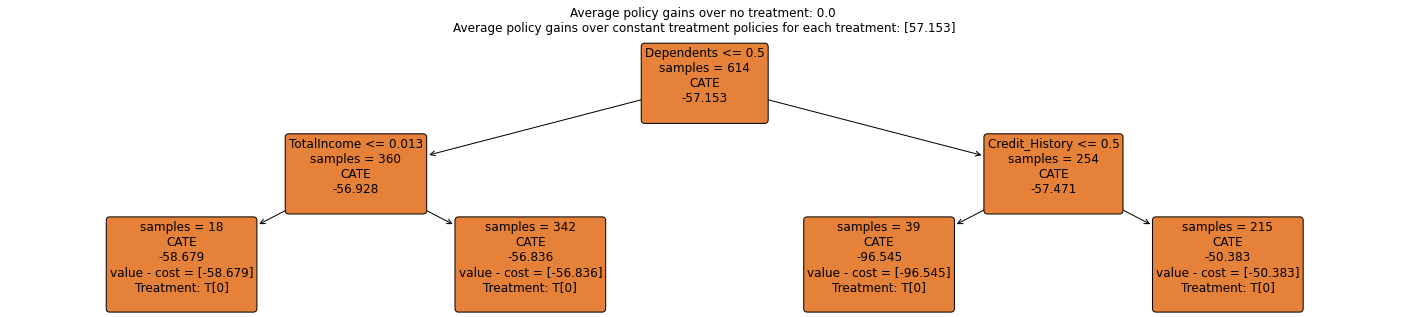

In [336]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_dw, test_data, sample_treatment_costs=0.2)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

We can also get a summary of the causal effect model

In [337]:
est_dw.summary(feature_names=X.columns)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
TotalIncome,-44.084,114.334,-0.386,0.7,-268.174,180.007
Credit_History,3.592,44.018,0.082,0.935,-82.683,89.866
Property_Area,13.959,13.436,1.039,0.299,-12.375,40.293
Loan_Amount_Term,-147.792,59.075,-2.502,0.012,-263.578,-32.007
Dependents,3.602,7.299,0.493,0.622,-10.705,17.908
Education,-1.201,13.303,-0.09,0.928,-27.275,24.873
Self_Employed,5.3,66.7,0.079,0.937,-125.428,136.029
LoanAmount,28.747,129.309,0.222,0.824,-224.694,282.188
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,80.747,59.282,1.362,0.173,-35.443,196.937


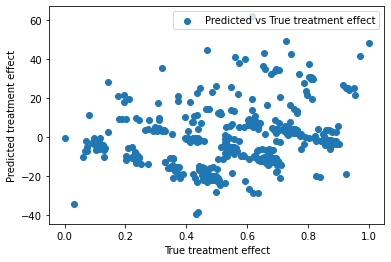

In [270]:
plt.scatter(test2['Financial_Advice'], est_dw.effect(test_data), label="Predicted vs True Financial_Advice effect")
plt.xlabel("True Financial_Advice effect")
plt.ylabel("Predicted Financial_Advice effect")
plt.legend()
plt.show()

Lets use an example to see how the BN is performing

In [308]:

# Get roi for each customer and possible Financial_Advice
potential_roi = est_dw.const_marginal_effect(X=X.values) - cost_fn(discretised_data)
# Add a column of 0s for no Financial_Advice

potential_roi = np.hstack([np.zeros(X.shape), potential_roi])

Financial_Advice_names = ["IncomeComb","Financial_Advice"]

We can also check for robustness of the causal effect. Check for p-value close to 1.

In [338]:
res_random = est_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.2926072641404817
New effect:0.6189711192988806
p value:0.4343158883905111



In [340]:
res_placebo = est_dw.refute_estimate(method_name="placebo_treatment_refuter", placebo_type="permute", 
                                     num_simulations=2)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.2926072641404817
New effect:22.67861907179692
p value:0.045738719648713226



Placebo treatment <0.05: determines that the treatment has a non effect on the dataset.